<a href="https://colab.research.google.com/github/Ilvecho/Project_5/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Import and load data

In [1]:
files.upload()
pass

Saving 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv to 2020Q1Q2Q3Q4-2021Q1 - South Korea - Dongkuk Steel Mill Co Ltd (001230).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv to 2020Q1Q2Q3Q4-2021Q1 - South Africa - Impala Platinum Holdings Ltd (IMPJ).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv to 2020Q1Q2Q3Q4-2021Q1 - Egypt - Medinet Nasr Housing (MNHD).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv to 2020Q1Q2Q3Q4-2021Q1 - Turkey - Koc Holding AS (KCHOL).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv to 2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv to 2020Q1Q2Q3Q4-2021Q1 - Argentina - Pampa Energia SA (PAMP).csv
Saving 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv to 2020Q1Q2Q3Q4-2021Q1 - Brazil - Minerva SA_Brazil (BEEF3).csv
Saving 2020Q1Q2Q

In [2]:
file_list = os.listdir('/content/')
data = {}

for filename in file_list:
  if filename.startswith('2020Q1'):
    country = filename.split(' - ')[1].strip()
    tmp_data = pd.read_csv(filename)[:-1]
    tmp_data['Date'] = pd.to_datetime(tmp_data['Date'])
    tmp_data.set_index('Date', inplace=True)

    try:
      data[country] = tmp_data['Price'].astype(float).sort_index()
    except:
      tmp_data['Price'] = tmp_data['Price'].apply(lambda x: x.replace(',', ''))
      data[country] = tmp_data['Price'].astype(float).sort_index()

In [ ]:
for key in data.keys():
  print('\n\n###########\n')
  print(data[key].info())

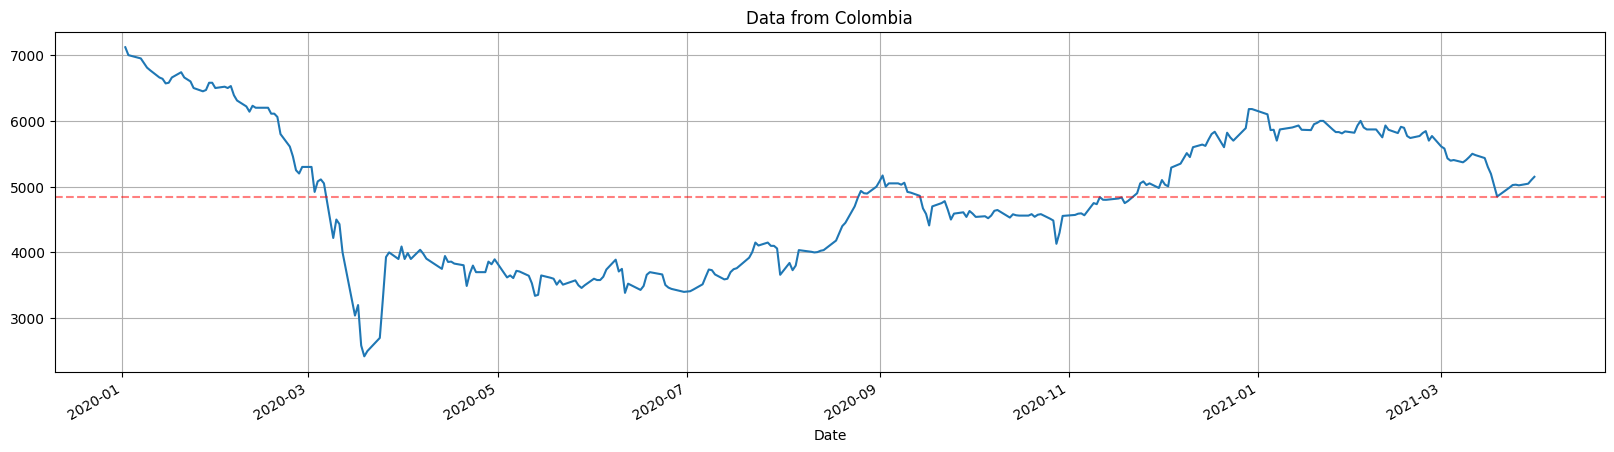

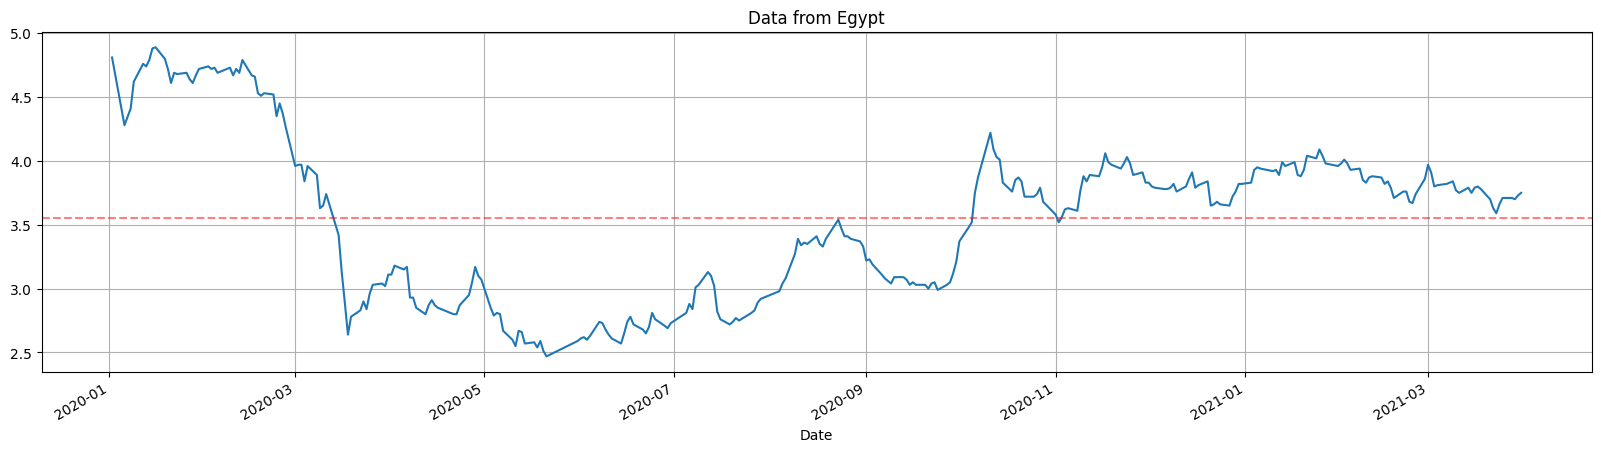

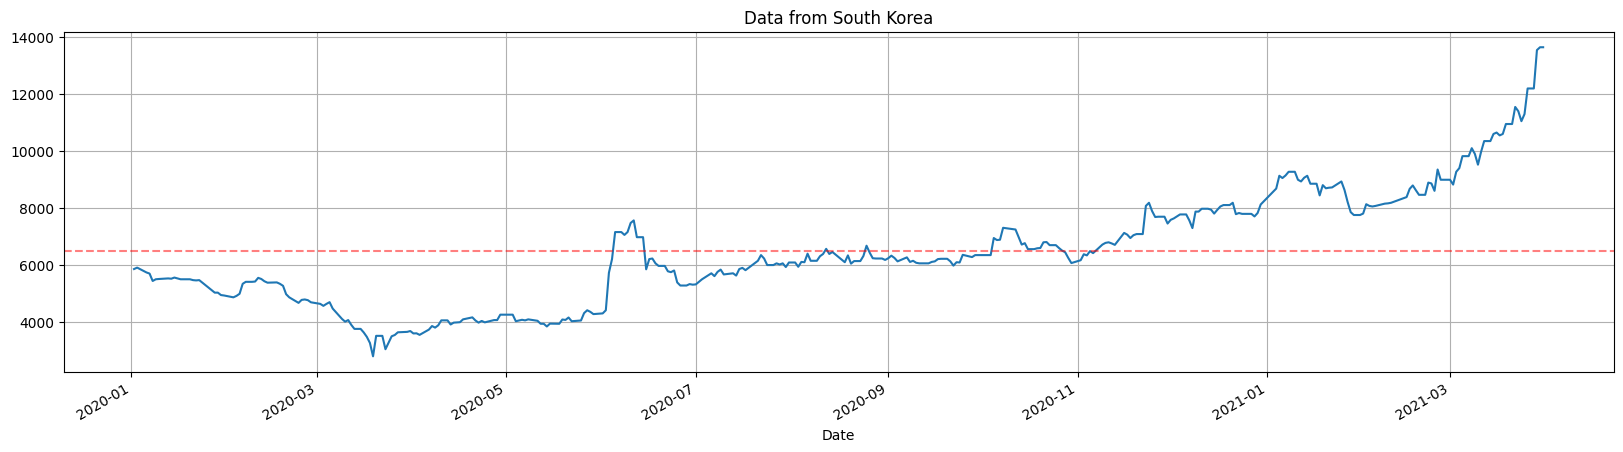

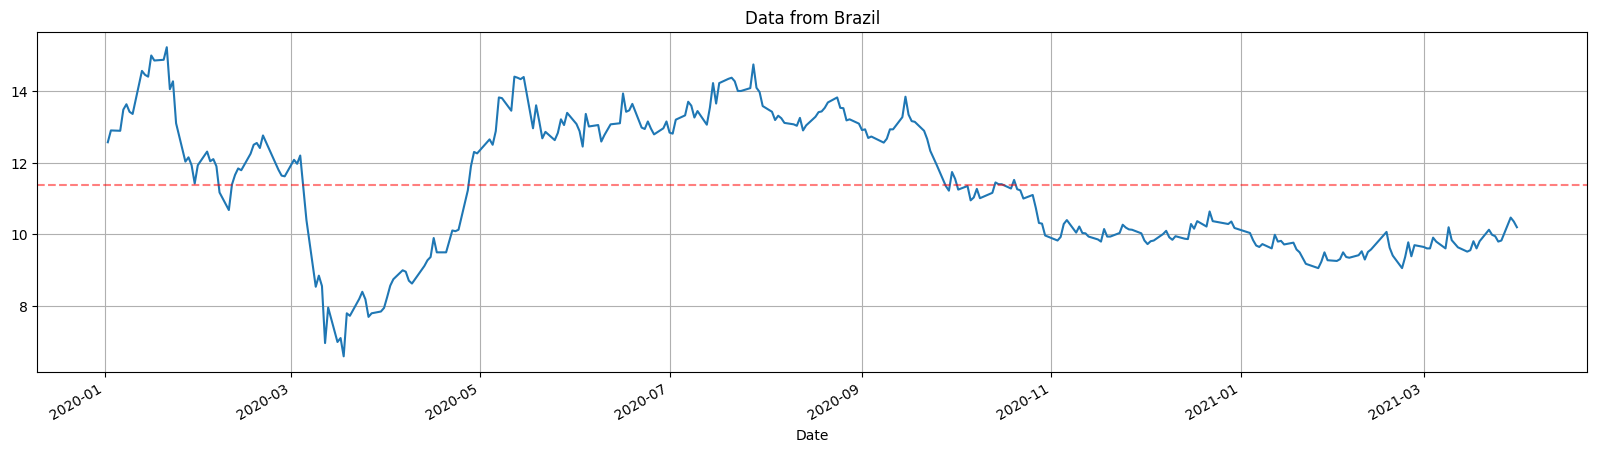

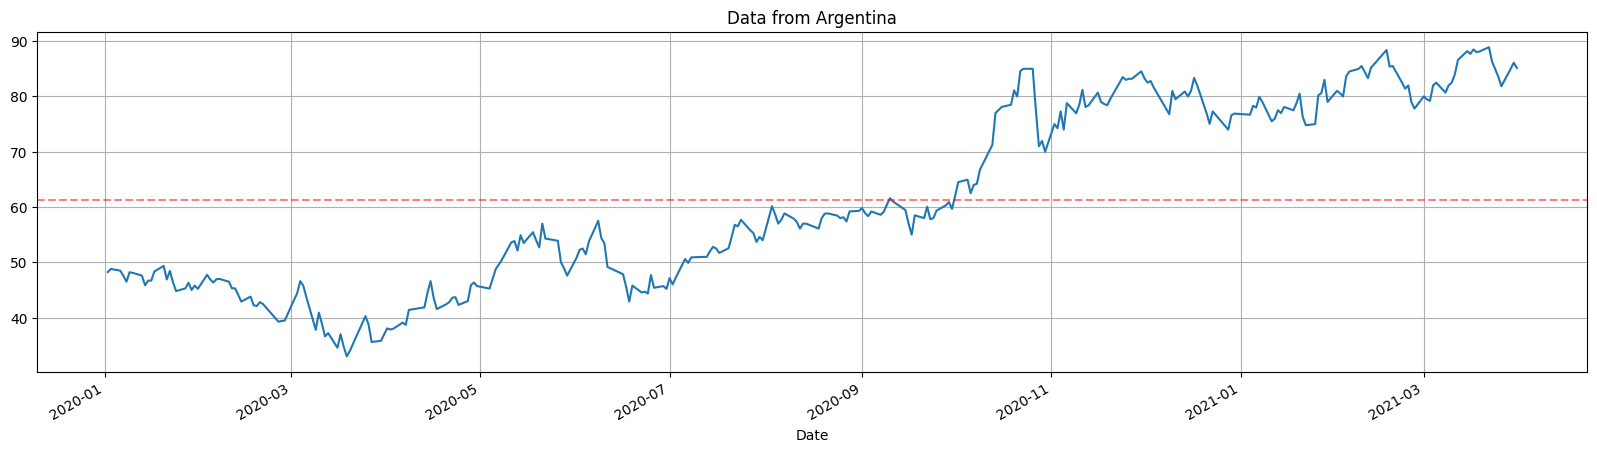

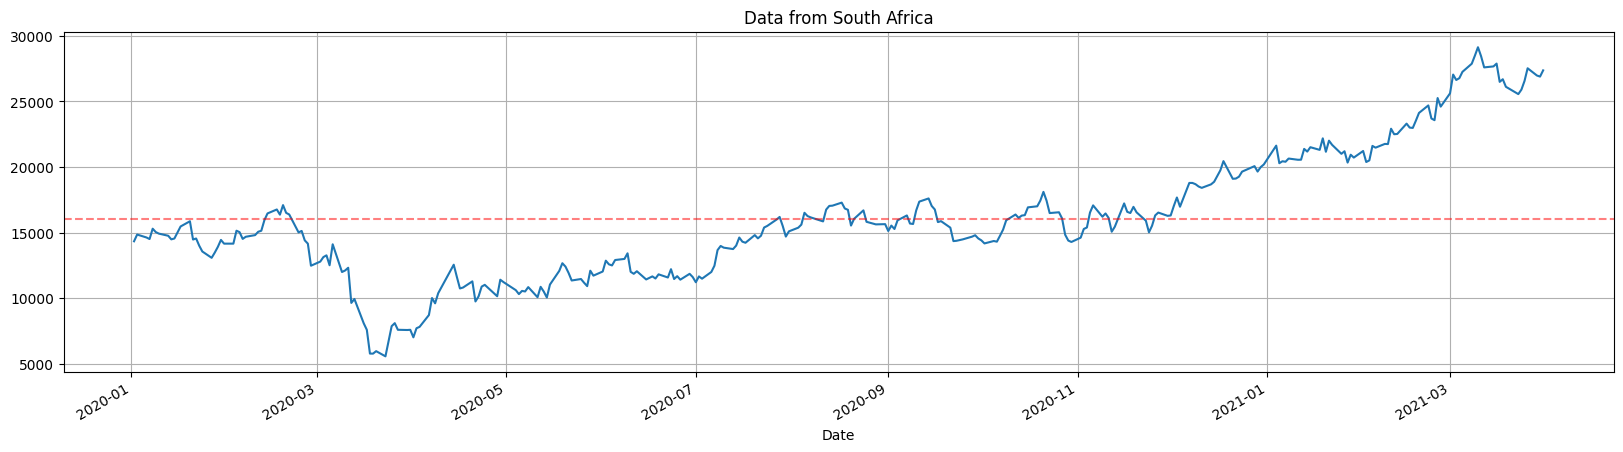

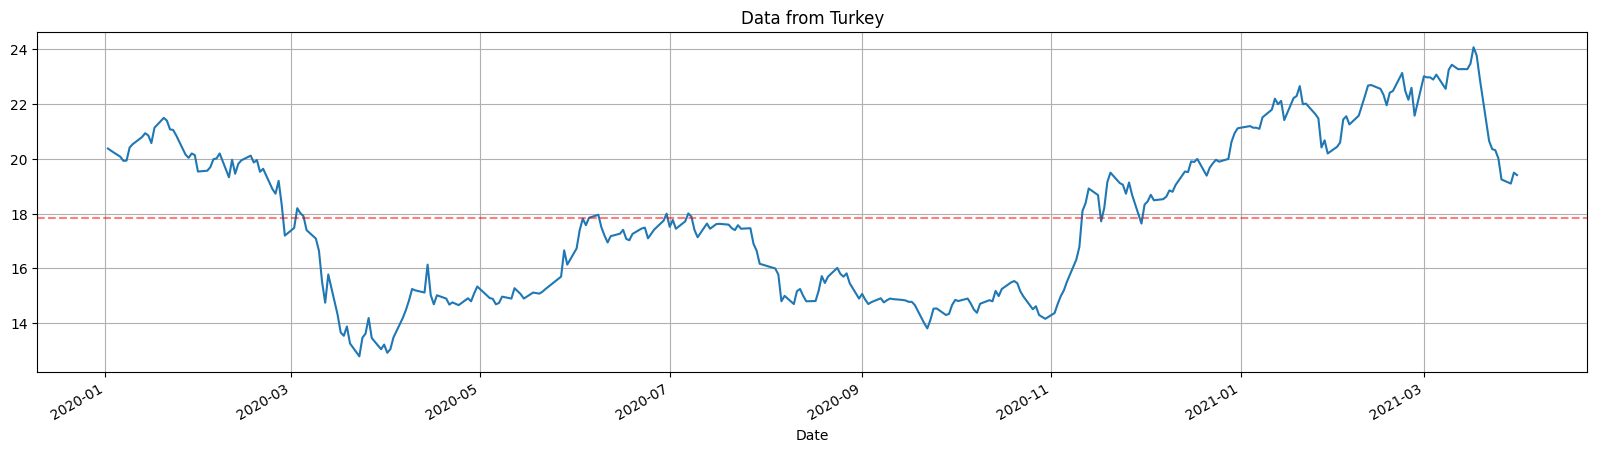

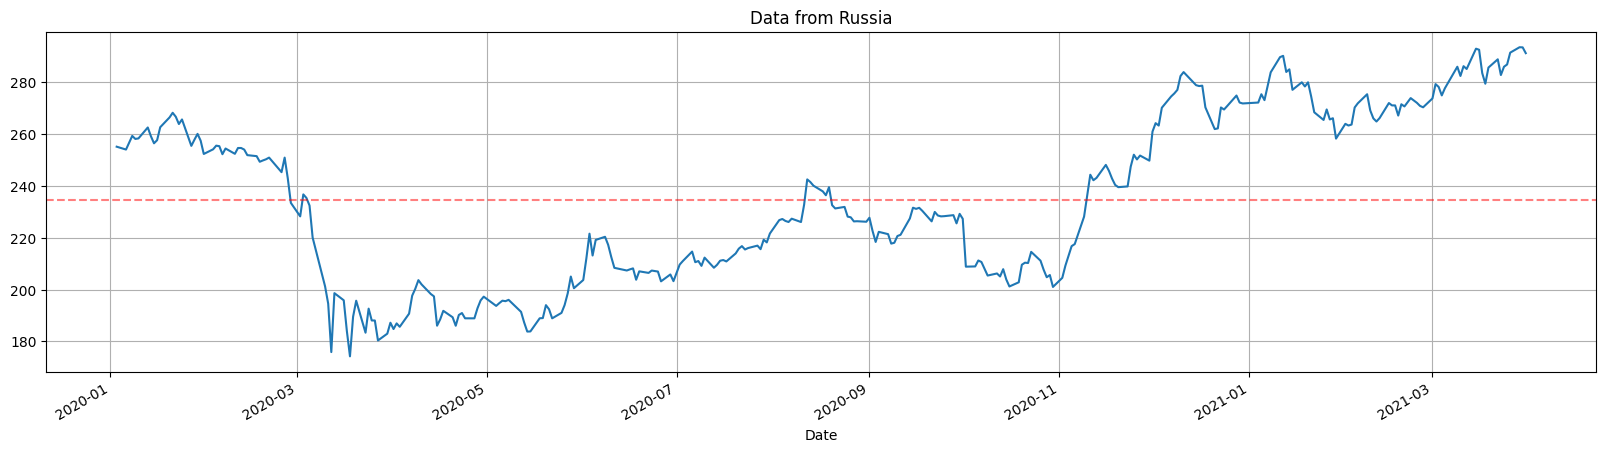

In [32]:
for key in data.keys():
  data[key].plot(figsize=(20,5), title=f'Data from {key}', grid='on')
  plt.axhline(y=data[key].mean(), color='red',  alpha=0.5, linestyle='--')
  plt.show()

We notice that the time series have **different values**.

Let's **normalize** them -> not sure if it's needed

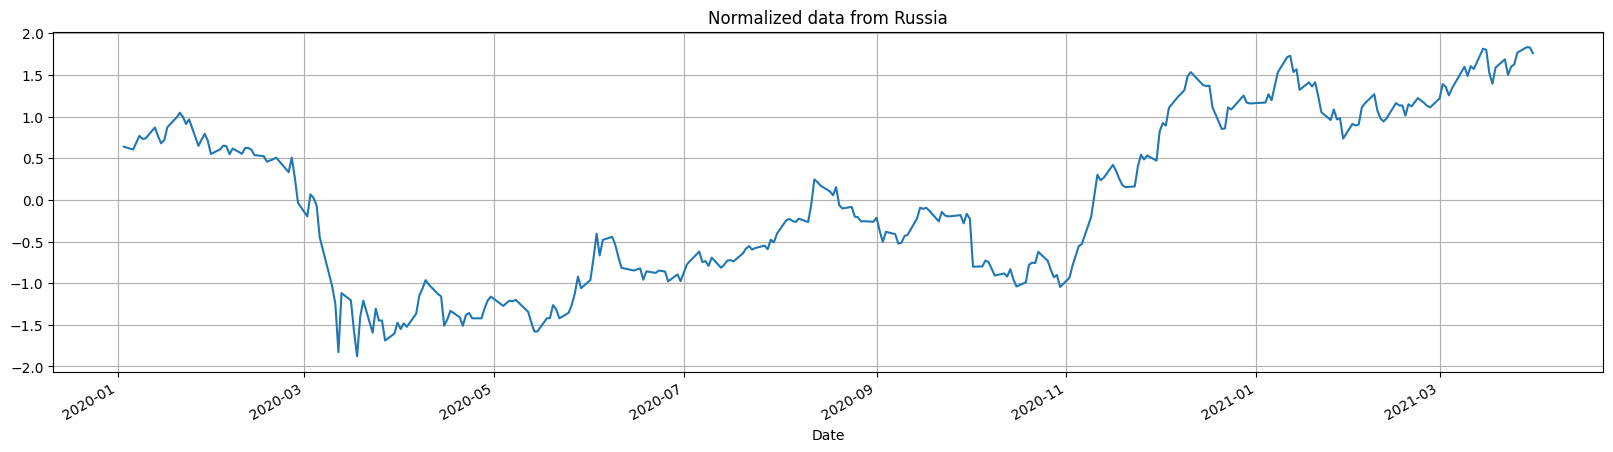

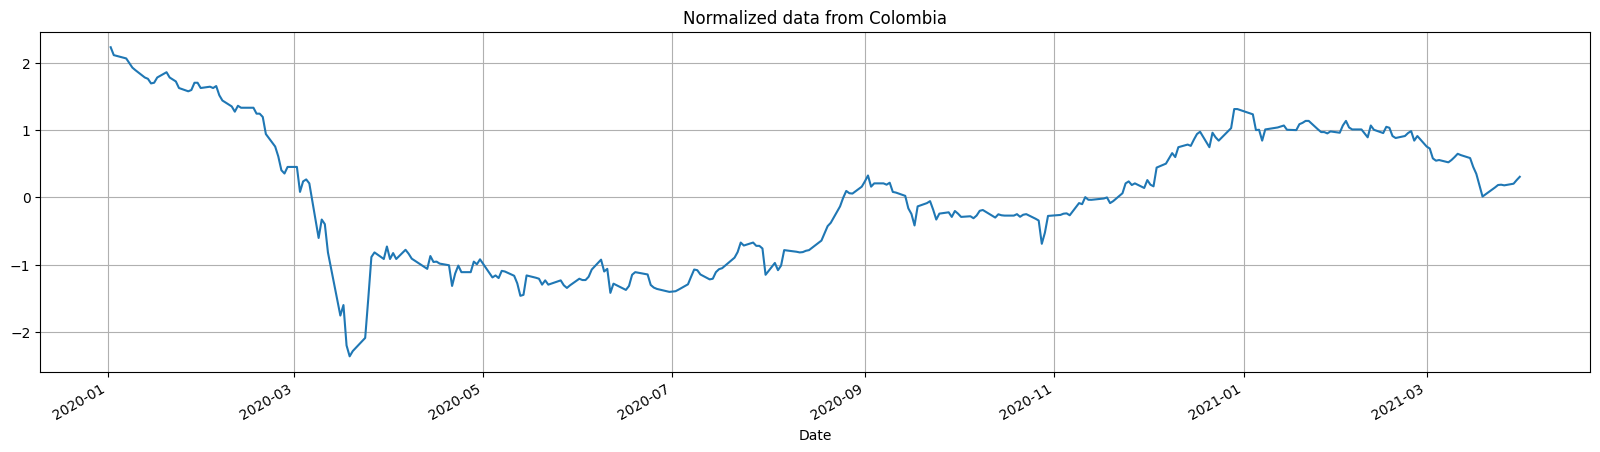

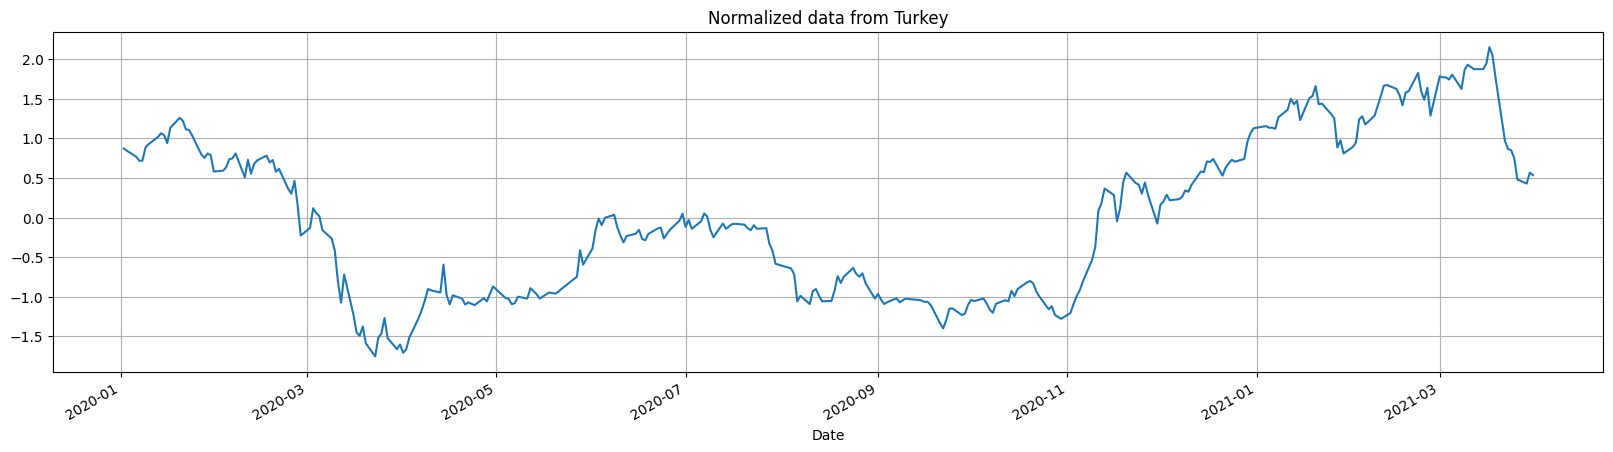

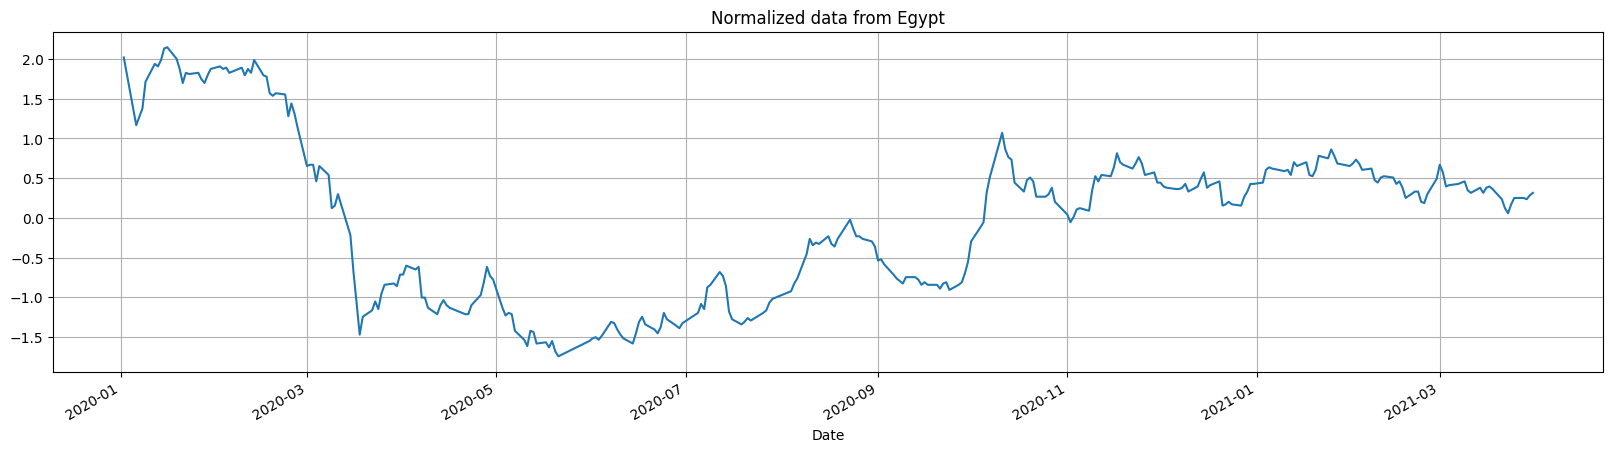

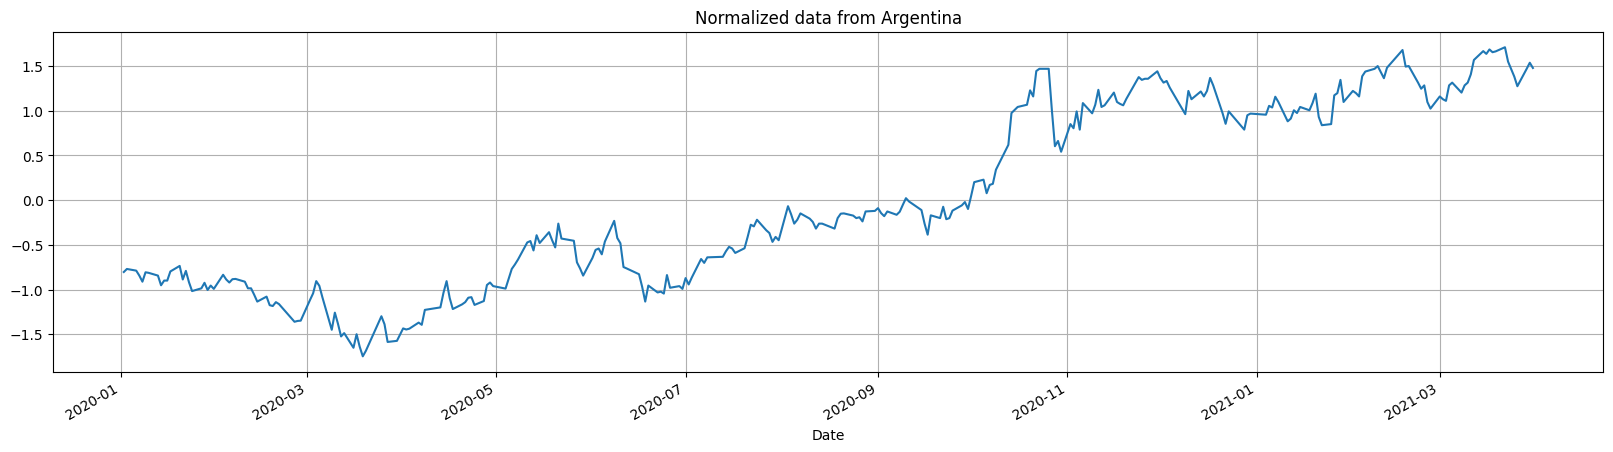

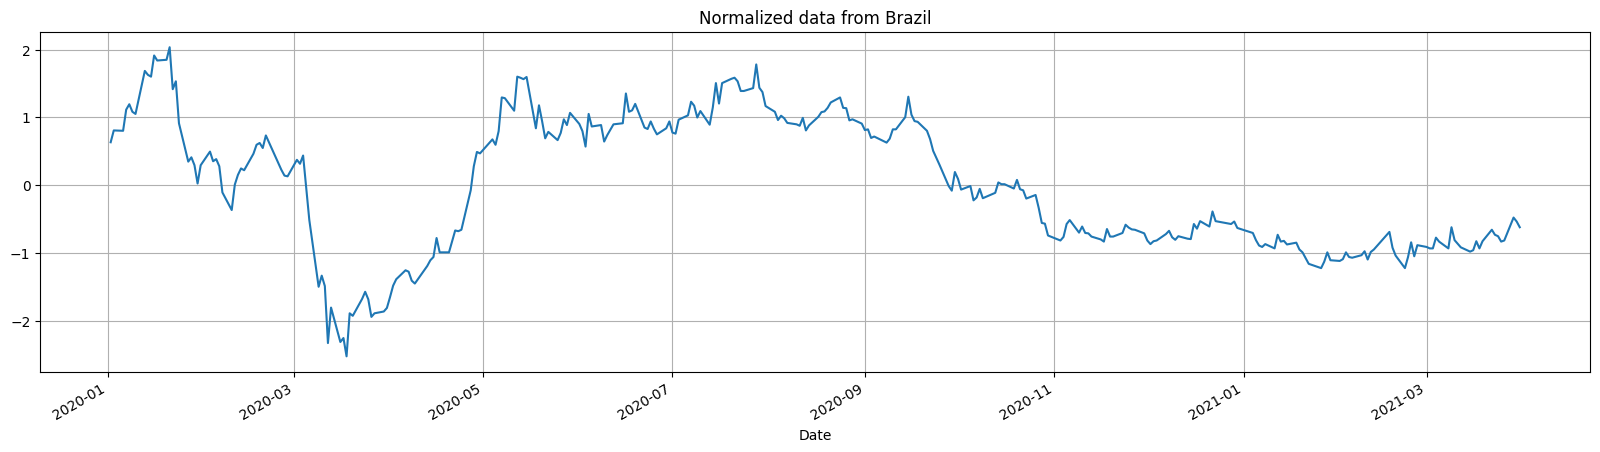

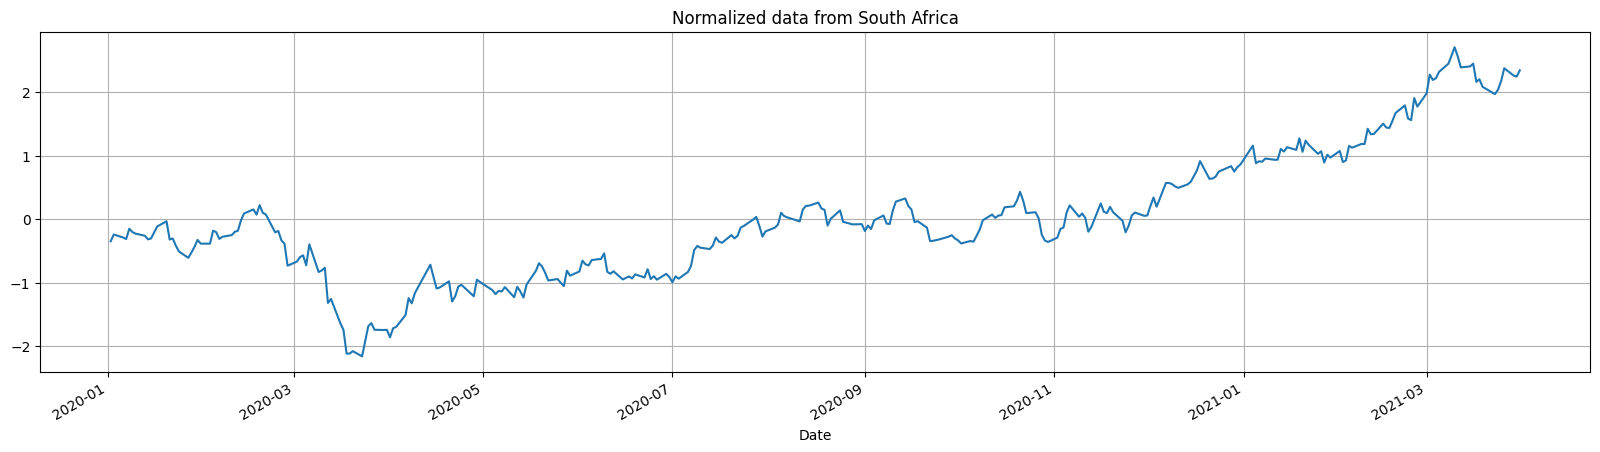

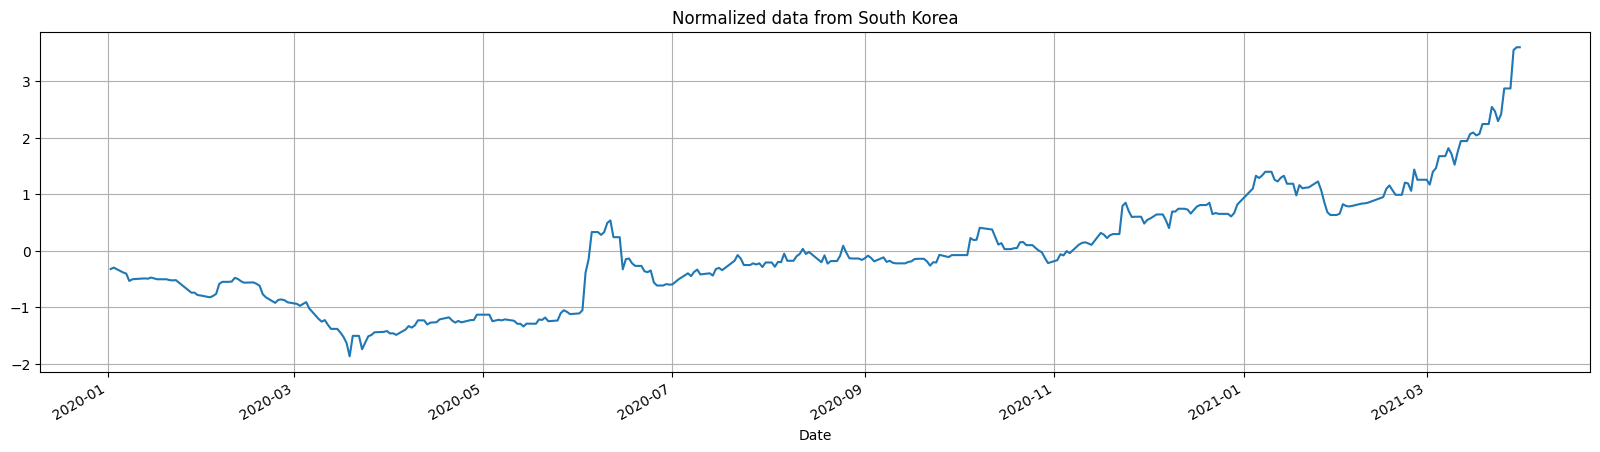

In [30]:
norm_data = {}

for key in data.keys():
  price = data[key]
  avg, dev = price.mean(), price.std()
  norm_price = (price - avg) / dev
  norm_data[key] = norm_price

  ax = norm_price.plot(figsize=(20,5), title=f'Normalized data from {key}', grid='on')
  plt.show()

# EDA - stationarity

We verify the stationarity of the time series using the **Augmented Dickey-Fuller** test

In [3]:
exp_data = data['Argentina']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

results = adfuller(exp_data)
print('The p-value of the series is: ', results[1])

The p-value of the series is:  0.8756756136964812


Since the p-value of the series is **greater than 0.5**, then the series is **not stationary**.

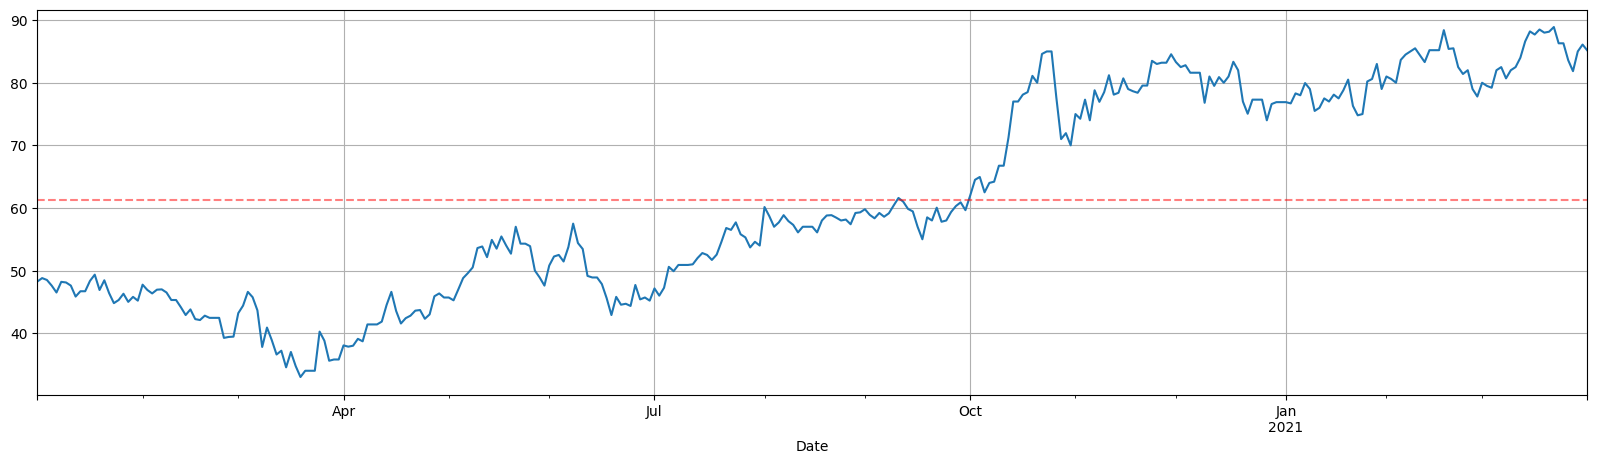

In [30]:
exp_data.plot(figsize=(20,5), grid='on')
plt.axhline(y=exp_data.mean(), color='red',  alpha=0.5, linestyle='--')
plt.show()

Looking at the data, most likely the non stationarity is due to the presence of a **trend** and (maybe) of a seasonal component.

Let's try and split the series in the components using the available decompose tool, assuming that the model is **additive**

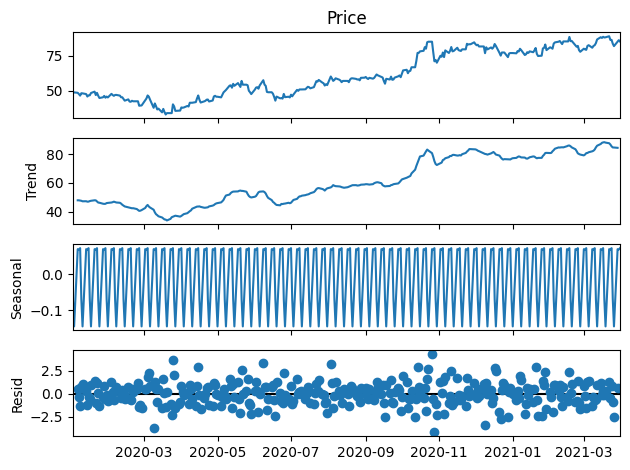

In [7]:
decomposition = sm.tsa.seasonal_decompose(exp_data, model='additive')
fig = decomposition.plot()

From the above graph we can see that a **trend** is clearly present, and maybe also a weekly seasonality.

Let's compute the **first order differences** to try removing the trend and verify the stationarity of the new series

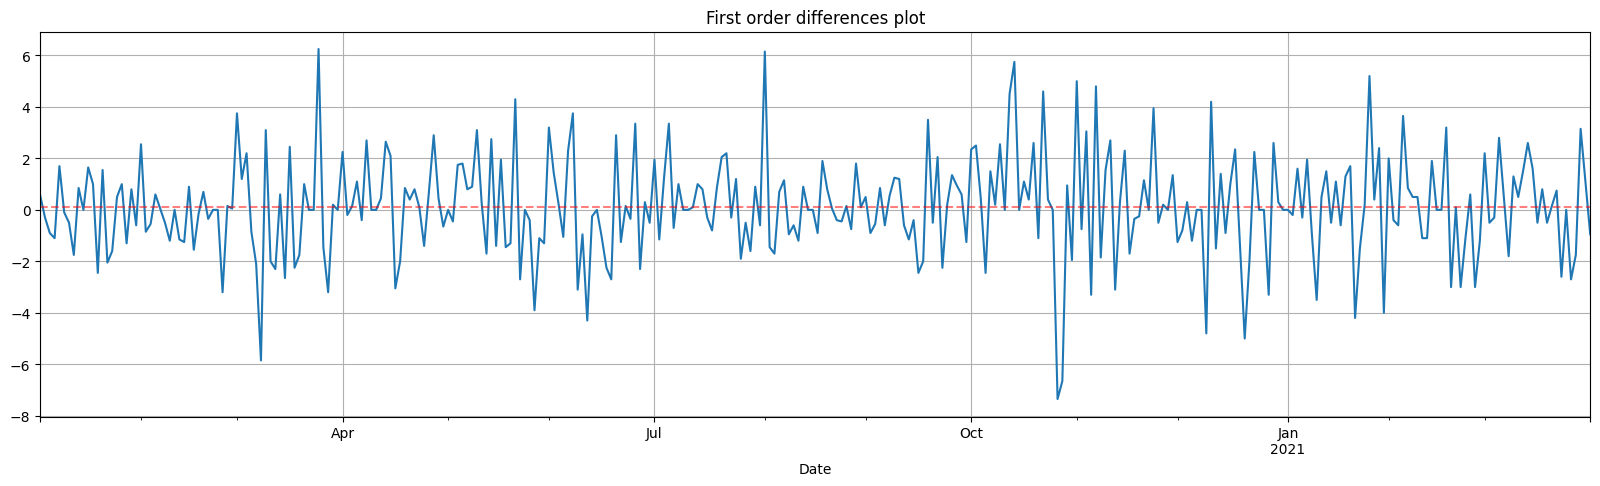

The p-value of the series is:  0.0


In [31]:
diff_exp_data = exp_data.diff().dropna()

diff_exp_data.plot(figsize=(20,5), title=f'First order differences plot', grid='on')
plt.axhline(y=diff_exp_data.mean(), color='red',  alpha=0.5, linestyle='--')
plt.show()

results = adfuller(diff_exp_data)
print('The p-value of the series is: ', results[1])

In this case the p-value is **zero**, so the series is stationary.

Hence, we will use an **integrator of order 1** in our ARIMA model.

# EDA - autocorrelation

let's compute the autocorrelation of the diff series

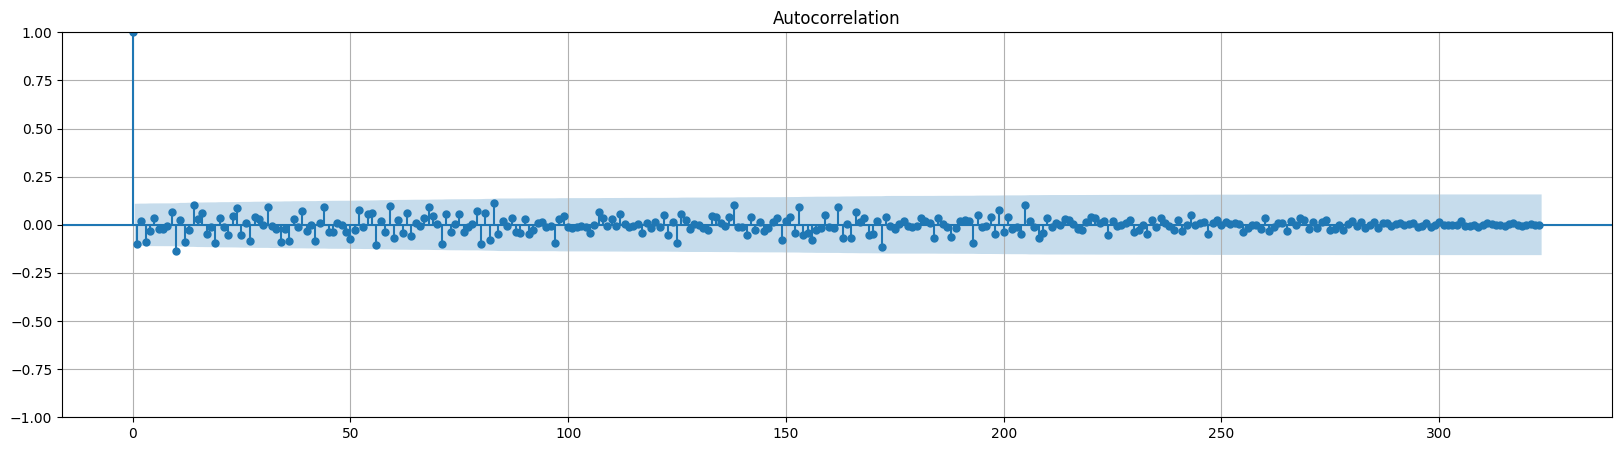

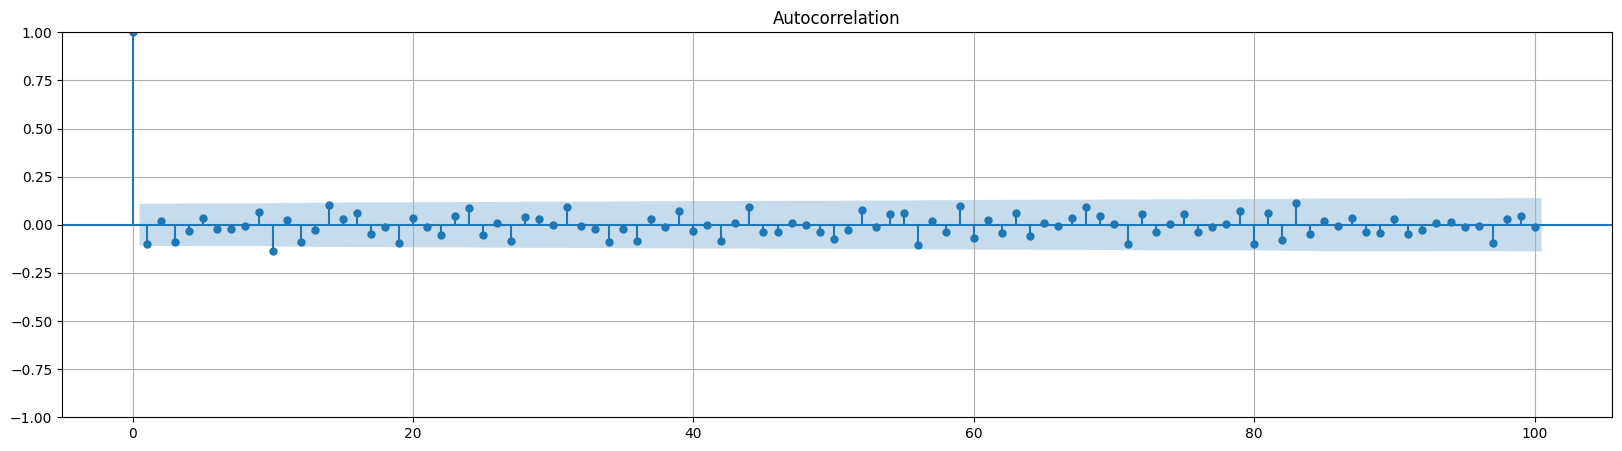

In [10]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(diff_exp_data, lags=len(diff_exp_data)-1, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(diff_exp_data, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

The significant lags shown by the ACF are 1, 3 and 10:

It could be that the lag 10 is due to seasonality (1 business week is 5 days, so it could be a two weeks seasonality).

While lags 1 and 3 could indicate relevance of the lags in the **moving average** part of the model

Let's now compute the **partial** autocorrelation of the diff series

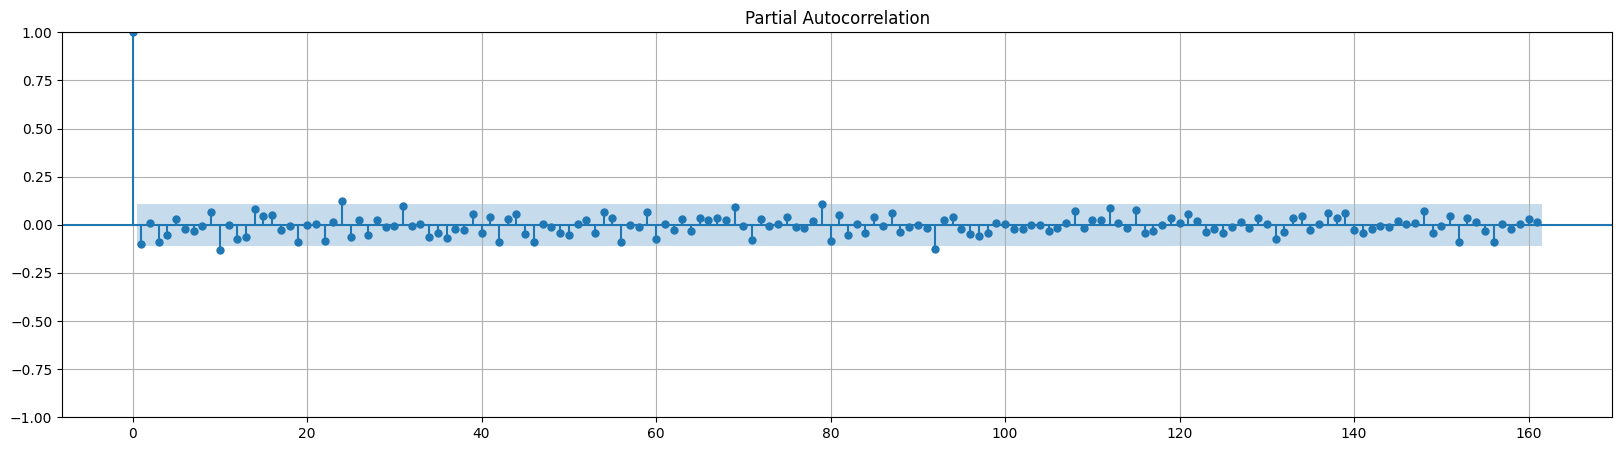

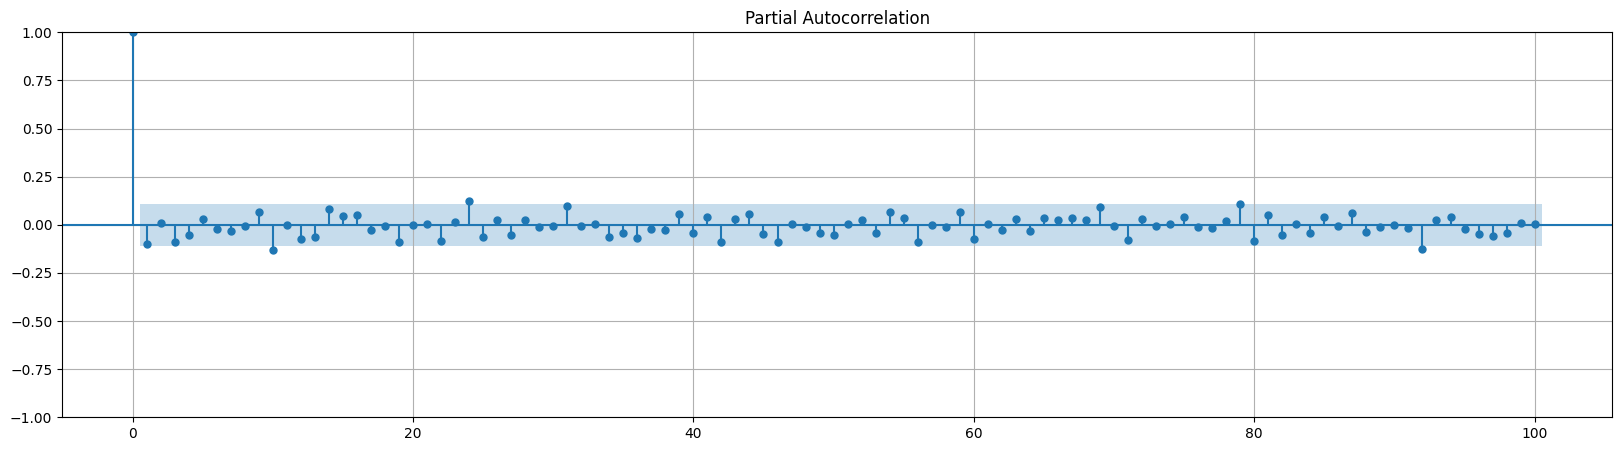

In [11]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=len(diff_exp_data)/2 -1, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

There are some lag values that have somehow **statistically meaningful** correlation:

1, 3, 10, 24, 79 and 92

Note that 1, 3, and 10 were also highlighted by the ACF.

Once again, we could consider lags 1 and 3 to tune the **auto regressive** part of the model.

But what if we analyze another time series?

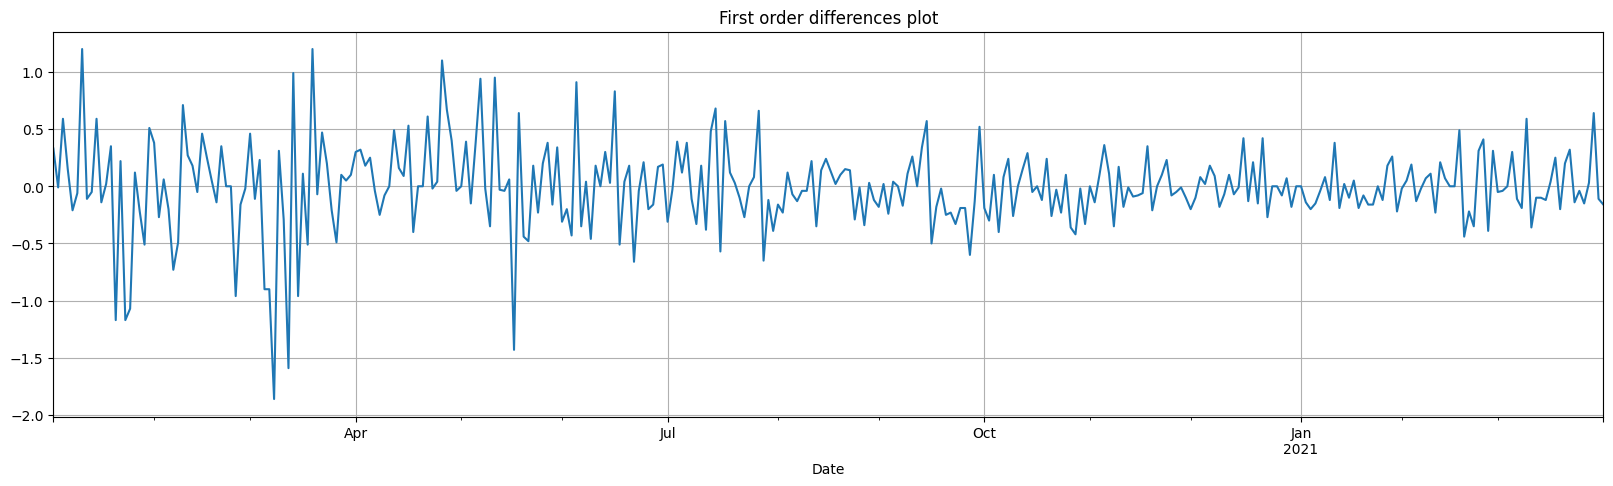

The p-value of the series is:  8.178484025778632e-14


In [14]:
exp_data = data['Brazil']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

diff_exp_data = exp_data.diff().dropna()

diff_exp_data.plot(figsize=(20,5), title=f'First order differences plot', grid='on')
plt.show()

results = adfuller(diff_exp_data)
print('The p-value of the series is: ', results[1])

Once again we consider the first order differences series as the original series shows a clear trend and it's not stationary

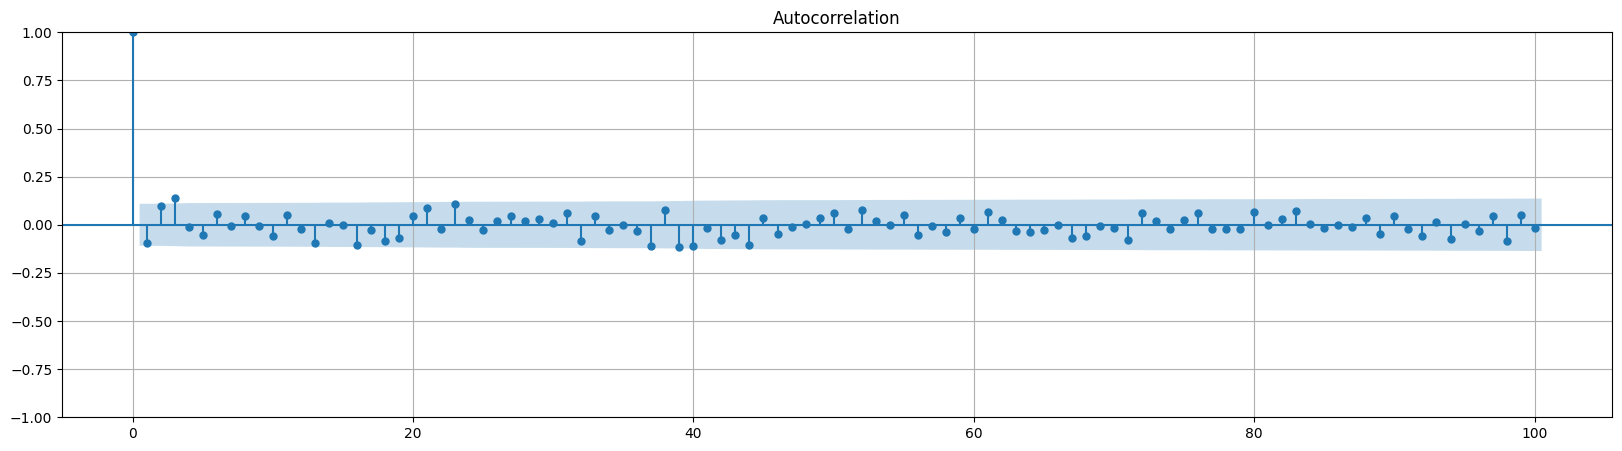

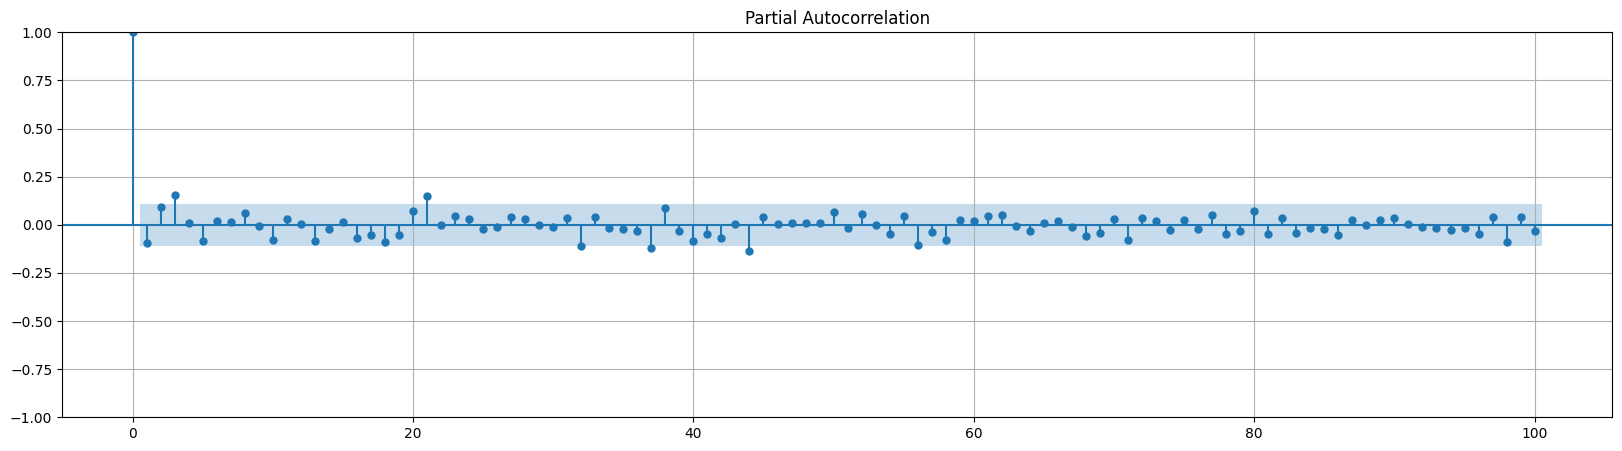

In [15]:
plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_acf(diff_exp_data, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
sm.graphics.tsa.plot_pacf(diff_exp_data, lags=100, ax=plt.gca())
plt.grid(True)
plt.show()

We observe that the relevant lag values are **different** than the previous ones:

1, 3, 21, 32, 37, 44, 56, 113

# Models

Let's continue working with the Argentina time series.

The EDA suggested to use as model a ARIMA(1,1,1) or ARIMA(3,1,3).

Let's try them both and see the difference in the results.



In [16]:
exp_data = data['Argentina']
exp_data = exp_data.asfreq('b')
exp_data = exp_data.fillna(method='ffill')

split the data in train and test

In [19]:
train_end = datetime(2020,12,31)

train_data = exp_data[:train_end]
test_data = exp_data[train_end + timedelta(days=1):]

Get the prediction timeframe (= test timeframe)

In [25]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

# ARIMA(1,1,1)

Fit the model

In [24]:
model = ARIMA(train_data, order=(1,1,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  261
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -546.363
Date:                Wed, 13 Sep 2023   AIC                           1098.727
Time:                        15:47:50   BIC                           1109.409
Sample:                    01-02-2020   HQIC                          1103.021
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5744      0.393     -1.462      0.144      -1.344       0.195
ma.L1          0.4811      0.426      1.130      0.258      -0.353       1.315
sigma2         3.9151      0.274     14.289      0.0

Compute the predictions

In [ ]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

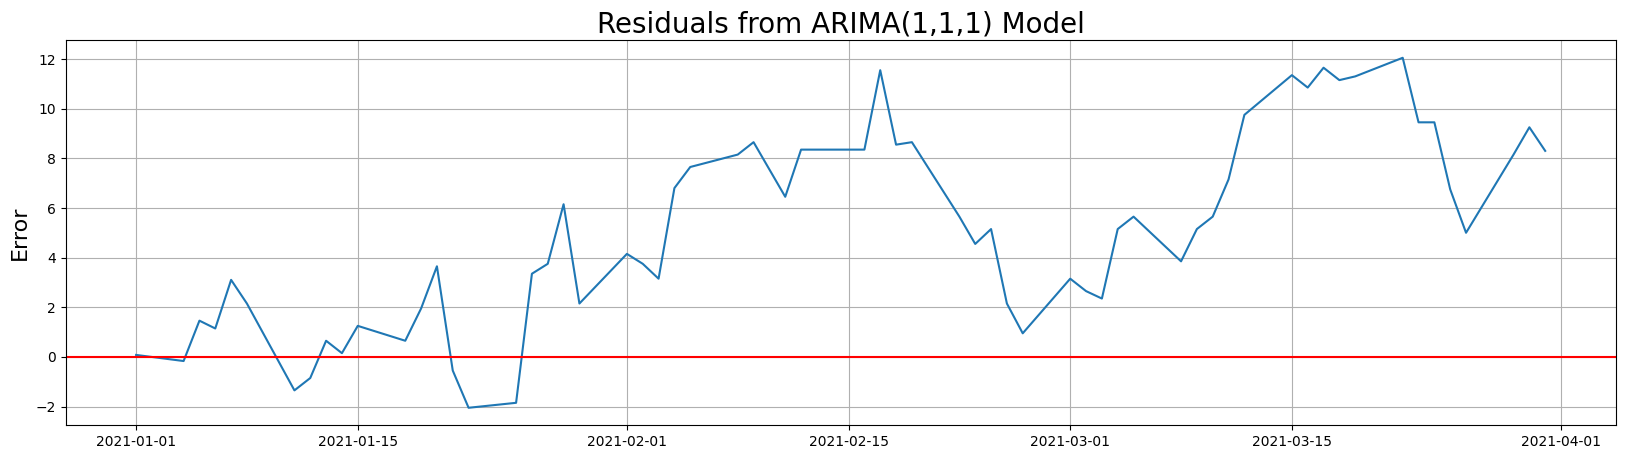

In [29]:
plt.figure(figsize=(20,5))
plt.plot(residuals)
plt.title('Residuals from ARIMA(1,1,1) Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r')
plt.grid('on')
plt.show()